In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [2]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_02_19_13_49_10_Rama horizontal scan'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [3]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

In [4]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	-2350.00	retention:0.115 +- 0.035
ivar:	-2350.00	retention:0.257 +- 0.035
ivar:	-2350.00	retention:0.014 +- 0.035
ivar:	-2350.00	retention:0.000 +- 0.035
ivar:	-2350.00	retention:0.000 +- 0.035
ivar:	-2325.00	retention:0.014 +- 0.039
ivar:	-2325.00	retention:0.429 +- 0.039
ivar:	-2325.00	retention:0.000 +- 0.039
ivar:	-2325.00	retention:0.000 +- 0.039
ivar:	-2325.00	retention:0.000 +- 0.039
ivar:	-2300.00	retention:0.000 +- 0.037
ivar:	-2300.00	retention:0.480 +- 0.037
ivar:	-2300.00	retention:0.014 +- 0.037
ivar:	-2300.00	retention:0.000 +- 0.037
ivar:	-2300.00	retention:0.000 +- 0.037
ivar:	-2275.00	retention:0.000 +- 0.038
ivar:	-2275.00	retention:0.398 +- 0.038
ivar:	-2275.00	retention:0.056 +- 0.038
ivar:	-2275.00	retention:0.000 +- 0.038
ivar:	-2275.00	retention:0.000 +- 0.038
ivar:	-2250.00	retention:0.000 +- 0.027
ivar:	-2250.00	retention:0.154 +- 0.027
ivar:	-2250.00	retention:0.169 +- 0.027
ivar:	-2250.00	retention:0.000 +- 0.027
ivar:	-2250.00	retention:0.000 +- 0.027


In [5]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

<IPython.core.display.Javascript object>


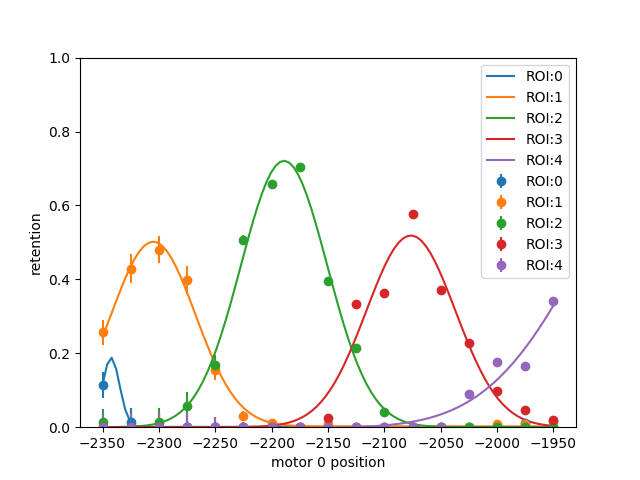

ROI:0, amplitude : 0.187636075545, location: -2342.44997008 , sigma:10.6870132159, offset:0.000843880725144
ROI:1, amplitude : 0.499754531829, location: -2305.00173821 , sigma:52.8097218243, offset:0.00223136941305
ROI:2, amplitude : 0.720624070758, location: -2188.95571601 , sigma:54.2030632476, offset:0.000209320063393
ROI:3, amplitude : 0.518311986038, location: -2076.46480323 , sigma:55.8908082146, offset:0.000382144398348
ROI:4, amplitude : 0.802720798452, location: -1834.43254922 , sigma:122.977103612, offset:-0.00257328012988


In [6]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[0.5,-2200,50,0]
roi_dependency=[0,100,0,0]
fitted_parameters=[]
for roi in [0,1,2,3,4]:
    
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    fit = curve_fit(gaussian,data,reten,guesses)
    print "ROI:{}, amplitude : {}, location: {} , sigma:{}, offset:{}".format(roi,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    fitted_parameters.append(fit[0])
    #print fit[0]
    xarray=np.linspace(np.min(data),np.max(data),100)
    yfit=gaussian(xarray, np.float(fit[0][0]),np.float(fit[0][1]),np.float(fit[0][2]),np.float(fit[0][3]))
    plt.plot(xarray,yfit,label="ROI:{}".format(roi),color=colors[roi])

plt.show()
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

In [23]:
print np.mean([0.0133514209878,0.0130698041537])

0.0132106125707


In [20]:
np.squeeze(retention['error'][0][0])

array([ 0.00385526,  0.00385526,  0.00385526,  0.00385526,  0.00385526])

In [37]:
np.squeeze(retention['error'])[2][2]

0.026591154480290473

In [32]:
retention['error']

array([[[ 0.00385526,  0.00385526,  0.00385526,  0.00385526,  0.00385526],
        [ 0.01091922,  0.01091922,  0.01091922,  0.01091922,  0.01091922],
        [ 0.02659115,  0.02659115,  0.02659115,  0.02659115,  0.02659115],
        [ 0.03782297,  0.03782297,  0.03782297,  0.03782297,  0.03782297],
        [ 0.03954599,  0.03954599,  0.03954599,  0.03954599,  0.03954599],
        [ 0.03477323,  0.03477323,  0.03477323,  0.03477323,  0.03477323],
        [ 0.02641161,  0.02641161,  0.02641161,  0.02641161,  0.02641161],
        [ 0.0161301 ,  0.0161301 ,  0.0161301 ,  0.0161301 ,  0.0161301 ],
        [ 0.00747533,  0.00747533,  0.00747533,  0.00747533,  0.00747533],
        [ 0.00511546,  0.00511546,  0.00511546,  0.00511546,  0.00511546],
        [ 0.00467327,  0.00467327,  0.00467327,  0.00467327,  0.00467327],
        [ 0.00670103,  0.00670103,  0.00670103,  0.00670103,  0.00670103],
        [ 0.00686513,  0.00686513,  0.00686513,  0.00686513,  0.00686513],
        [ 0.00664806,  0.